## 1. 导入模块

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

from tensorflow import keras
import tensorflow as tf
import sys
import os
import time
import datetime

for module in [np, pd, mpl, sklearn, keras, tf]:
    print(module.__name__, module.__version__)
    
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpus[0], True)

numpy 1.18.1
pandas 0.25.3
matplotlib 3.1.2
sklearn 0.22.1
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf
tensorflow 2.1.0


## 2. 加载数据

In [2]:
imdb = keras.datasets.imdb
vocab_size = 10000
index_from = 3

# 加载数据，词的数量为 vocab_size， 从index_from=3 后开始安排index
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size, index_from=index_from)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# word to index
word2index = imdb.get_word_index()
# 因为数据是从 index_from=3 开始安排的，所以，word2index 往后移3位
word2index = {word:(idx+3) for word, idx in word2index.items()} 

word2index["<PAD>"] = 0
word2index["<START>"] = 1
word2index["<UNK>"] = 2
word2index["<END>"] = 3

reversed_word2index = {v:k for k, v in word2index.items()}

(25000,) (25000,)
(25000,) (25000,)


In [3]:
# 解析数据
def decode_review(text_ids):
    return " ".join([reversed_word2index[ids] for ids in text_ids])

print(decode_review(x_train[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

In [4]:
# 补全数据
max_length = 500

x_train = keras.preprocessing.sequence.pad_sequences(
    x_train, # list of list
    value=word2index["<PAD>"], # 填充数
    padding="post",  # 往后填充
    maxlen=max_length) # 最大长度

x_test = keras.preprocessing.sequence.pad_sequences(
    x_test, # list of list
    value=word2index["<PAD>"],
    padding="post",
    maxlen=max_length)

# print(x_train[0])

## 3. RNN建模训练

In [5]:
embedding_dim = 16
batch_size = 128

def build_model(vocab_size, embedding_dim, max_length):
    model = keras.models.Sequential([
        # 输入数据：batch_size * max_length
        
        # 词表矩阵          vocab_size * embedding_dim
        # 每个词输入的矩阵：max_length * embedding_dim
        # 每批词的输出矩阵：batch_size * max_length * embedding_dim
        keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length), # batch_size * max_length * embedding_dim
        
        keras.layers.SimpleRNN(units=64, return_sequences=False), # batch_size * 64
        keras.layers.Dense(64, activation="relu"),  # batch_size * 64
        keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

simple_rnn_model = build_model(vocab_size, embedding_dim, max_length)
simple_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                5184      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 169,409
Trainable params: 169,409
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = simple_rnn_model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=batch_size)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 35s 2ms/sample - loss: 0.6905 - accuracy: 0.5078 - val_loss: 0.6935 - val_accuracy: 0.5066
Epoch 2/30
20000/20000 [==============================] - 35s 2ms/sample - loss: 0.6884 - accuracy: 0.5173 - val_loss: 0.6947 - val_accuracy: 0.5086
Epoch 3/30
20000/20000 [==============================] - 35s 2ms/sample - loss: 0.6862 - accuracy: 0.5177 - val_loss: 0.6935 - val_accuracy: 0.5076
Epoch 4/30
20000/20000 [==============================] - 34s 2ms/sample - loss: 0.6809 - accuracy: 0.5226 - val_loss: 0.6950 - val_accuracy: 0.5066
Epoch 5/30
20000/20000 [==============================] - 35s 2ms/sample - loss: 0.6768 - accuracy: 0.5204 - val_loss: 0.6976 - val_accuracy: 0.4962
Epoch 6/30
20000/20000 [==============================] - 35s 2ms/sample - loss: 0.6754 - accuracy: 0.5217 - val_loss: 0.6981 - val_accuracy: 0.5072
Epoch 7/30
20000/20000 [==============================] -

(0, 1.8)

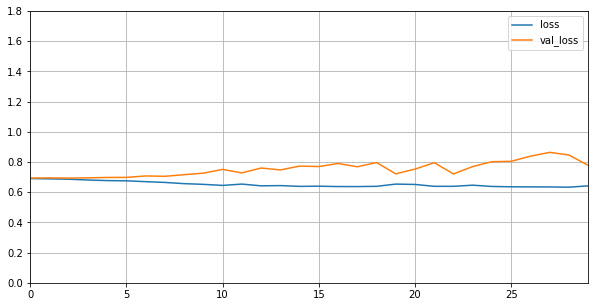

In [8]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot(figsize=(10, 5))
plt.grid(True)
plt.ylim(0, 1.8)

(0, 1)

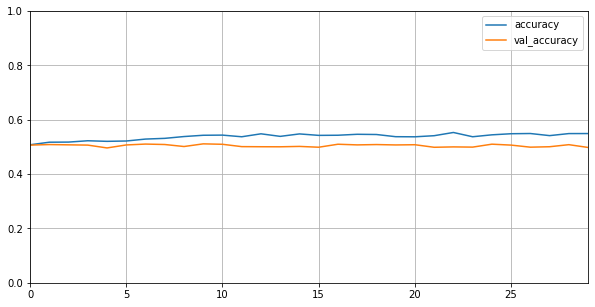

In [9]:
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot(figsize=(10, 5))
plt.grid(True)
plt.ylim(0, 1)

## 4. 双向两层RNN

In [11]:
def build_model(vocab_size, embedding_dim, max_length):
    model = keras.models.Sequential([
        # 输入数据：batch_size * max_length
        
        # 词表矩阵          vocab_size * embedding_dim
        # 每个词输入的矩阵：max_length * embedding_dim
        # 每批词的输出矩阵：batch_size * max_length * embedding_dim
        keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length), # batch_size * max_length * embedding_dim
        
        keras.layers.Bidirectional(keras.layers.SimpleRNN(units=64, return_sequences=True)), # batch_size * max_length * 128
        keras.layers.Bidirectional(keras.layers.SimpleRNN(units=64, return_sequences=False)), # batch_size * 128
        
        keras.layers.Dense(64, activation="relu"),  # batch_size * 64
        keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

bi_rnn_model = build_model(vocab_size, embedding_dim, max_length)
bi_rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 128)          10368     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               24704     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 203,393
Trainable params: 203,393
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = bi_rnn_model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=batch_size)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 134s 7ms/sample - loss: 0.6985 - accuracy: 0.5074 - val_loss: 0.6888 - val_accuracy: 0.5380
Epoch 2/30
20000/20000 [==============================] - 132s 7ms/sample - loss: 0.6401 - accuracy: 0.6338 - val_loss: 0.5885 - val_accuracy: 0.6946
Epoch 3/30
20000/20000 [==============================] - 132s 7ms/sample - loss: 0.4918 - accuracy: 0.7681 - val_loss: 0.7237 - val_accuracy: 0.6740
Epoch 4/30
20000/20000 [==============================] - 134s 7ms/sample - loss: 0.3641 - accuracy: 0.8448 - val_loss: 0.4585 - val_accuracy: 0.8074
Epoch 5/30
20000/20000 [==============================] - 132s 7ms/sample - loss: 0.2726 - accuracy: 0.8918 - val_loss: 0.5468 - val_accuracy: 0.8128
Epoch 6/30
20000/20000 [==============================] - 134s 7ms/sample - loss: 0.2279 - accuracy: 0.9157 - val_loss: 0.4800 - val_accuracy: 0.8094
Epoch 7/30
20000/20000 [===========================